In [245]:
import deribit_data as dm
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

In [25]:
# Run this command below to download the most recent data

btc_data = dm.Options("BTC")
btc_data.collect_data(save_csv=True)




ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [75]:
# Pre-loading downloaded data
btc_df = pd.read_csv("btc_options_data-2021_Jun_09-15_02_24.csv", index_col=0)
btc_df['mid_iv'] = (btc_df.bid_iv + btc_df.ask_iv)/2



print(btc_df.columns)



Index(['underlying_price', 'underlying_index', 'timestamp', 'stats', 'state',
       'settlement_price', 'open_interest', 'min_price', 'max_price',
       'mark_price', 'mark_iv', 'last_price', 'interest_rate',
       'instrument_name', 'index_price', 'greeks', 'estimated_delivery_price',
       'change_id', 'bids', 'bid_iv', 'best_bid_price', 'best_bid_amount',
       'best_ask_price', 'best_ask_amount', 'asks', 'ask_iv', 'option_type',
       'mid_iv'],
      dtype='object')


In [177]:
# Confirm correct date
#pd.to_datetime(date, unit='ms')
def somme_ponderee(X):
    s = 0
    d = 0
    
    for x in json.loads(X):

        
        if len(x)<2:
            return 0.0
        s += x[0]*x[1]
        d += x[1]
    if d!= 0:
        s/= d
    else:
        return 0.0
    return s

def to_date(ts):
    return str(datetime.datetime.fromtimestamp(ts))


def to_ts(date):
    if '/' in date: #Format dd/mm/yy
        return int(time.mktime(datetime.datetime.strptime(date, "%d/%m/%Y").timetuple()))
    elif '-' in date: #Format yy-mm-dd
        return int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()))
    else: # FORMAT 13DEC21
        day = date[:2]
        year = date[-2:]
        month = date[2:-2]

        month_d = { 'JAN':'01',
                    'FEB':'02',
                    'MAR':'03',
                    'APR':'04',
                    'MAY':'05',
                    'JUN':'06',
                    'JUL':'07',
                    'AUG':'08',
                    'SEP':'09',
                    'OCT':'10',
                    'NOV':'11',
                    'DEC':'12'}


        return to_ts(day+'/'+month_d[month]+'/20'+year)
    
def ms_to_s(ts):
    return int(ts/1000)

def ts_to_days(ts):
    return ts/(3600*24)


In [229]:
# Only extract the call options
btc_call = btc_df[btc_df.option_type == 'C']
EXP_DATES, STRIKES = [], []


###
for inst_name in btc_call['instrument_name']:
    el = inst_name.split('-')
    EXP_DATES.append(el[1])
    STRIKES.append(el[2])
    
btc_call['_T'] = EXP_DATES
btc_call['K'] = STRIKES




/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [232]:
date = '10JUN21'
#btc_subset = btc_call[btc_call['T'] == date].sort_values('K')
btc_subset = btc_call.sort_values('K')

btc_subset['bids'] = btc_subset['bids'].apply(somme_ponderee)
btc_subset['asks'] = btc_subset['asks'].apply(somme_ponderee)

btc_subset['mid'] = (btc_subset.bids+btc_subset.asks)/2

#btc_call.head()

# Drop rows where IV is null
btc_subset = btc_subset.drop(btc_subset[btc_subset.mid_iv == 0.0].index)

btc_subset['_T'] = btc_subset['_T'].apply(to_ts) - datetime.datetime.timestamp(datetime.datetime.today())#btc_subset['timestamp'].apply(ms_to_s)
btc_subset['_T'] = btc_subset['_T'].apply(ts_to_days)
btc_subset['S'] = btc_subset['underlying_price']

btc_data = btc_subset[['S','K', '_T', 'mid_iv','bids','asks','last_price','mid']]
btc_data.head()
                    



#print(btc_subset['mid_iv'])

,S,K,_T,mid_iv,bids,asks,last_price,mid
192,34884.33,10000,15.250547,161.085,0.710109,0.717654,0.6985,0.713881
373,36728.77,100000,288.292214,98.790,0.064224,0.091302,0.0840,0.077763
242,34892.11,100000,15.250547,90.805,0.000000,0.009627,0.0005,0.004813
360,36218.00,100000,204.292214,100.615,0.035959,0.110549,0.0490,0.073254
177,35405.05,100000,106.250547,103.710,0.007942,0.240276,0.0120,0.124109


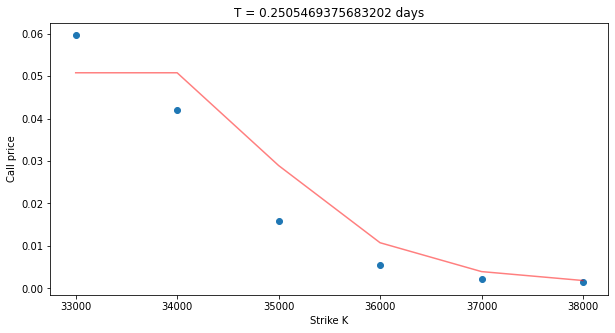

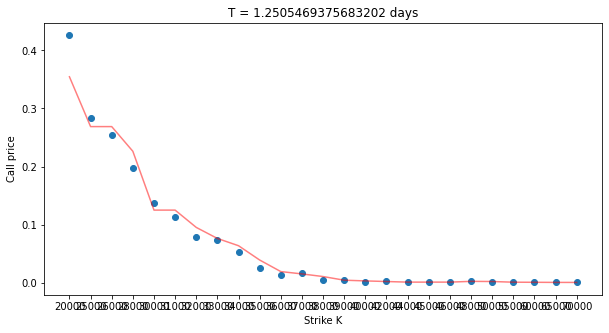

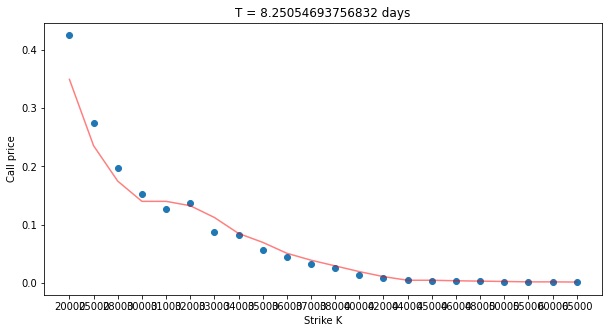

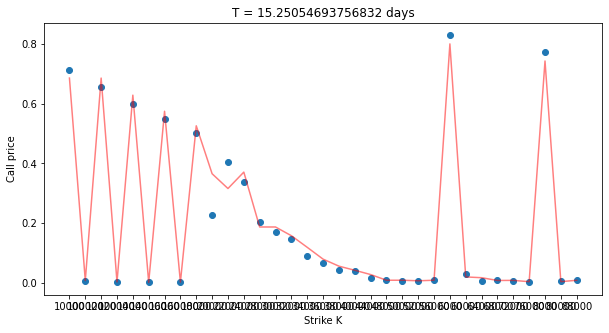

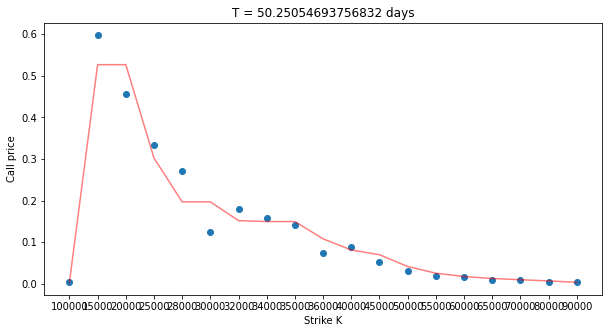

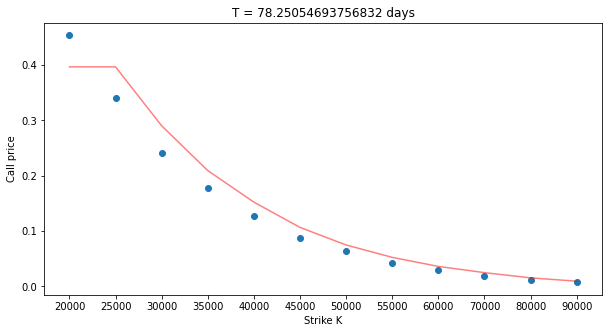

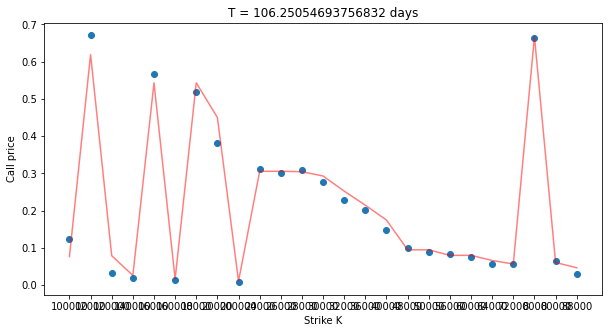

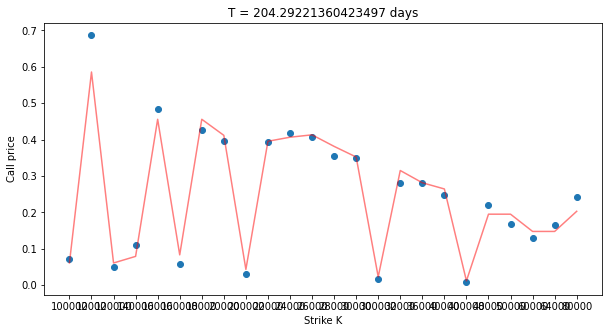

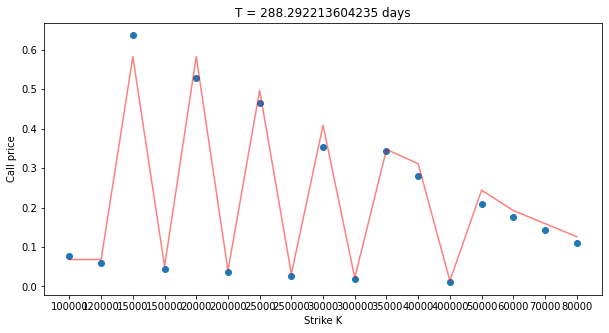

In [252]:
res = []
for i in list(btc_data.sort_values('_T')['_T']):
    if i not in res:
        res.append(i)

plt.rcParams["figure.figsize"] = (10,5)

for T in res:
    
    #plt.plot(btc_data[btc_data._T == T]['K'],btc_data[btc_data._T == T]['mid'])
    plt.xlabel('Strike K')
    plt.ylabel('Call price')
    plt.title('T = {} days'.format(T))
    
    
    
    btc_knn = KNeighborsRegressor(n_neighbors=2)
    
    btc_knn.fit(btc_data[btc_data._T == T].K.values.reshape(-1,1),
                btc_data[btc_data._T == T].mid.values.reshape(-1,1))


    btc_smoothed_fit = btc_knn.predict(btc_data[btc_data._T == T].K.values.reshape(-1,1))
    
    plt.plot(btc_data[btc_data._T == T].K, btc_smoothed_fit, c='r', alpha=0.50, label='KNN Fit')
    
    plt.scatter(btc_data[btc_data._T == T].K, btc_data[btc_data._T == T].mid) #label='Mid Implied Volatility')
    plt.show()

    
